# Check model performance depending on station

#### Samples generated with random window

In [1]:
import pandas as pd
from obspy.core.event import read_events
import matplotlib.pyplot as plt

import seisbench.models as sbm
import torch
import torch.nn as nn

import seisbench.data as sbd
import seisbench.generate as sbg
import seisbench.models as sbm
from seisbench.util import worker_seeding
import numpy as np
from torch.utils.data import DataLoader
from pathlib import Path
import wandb
import os
import sys

from pathlib import Path
cwd = str(Path.cwd().parent)
sys.path.append(cwd)
from scripts import train


wandb: Currently logged in as: kmilian (epos). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /Users/krystynamilian/.netrc


In [2]:
model = train.load_model()

run = wandb.init()
artifact = run.use_artifact('epos/training_seisbench_models_on_igf_data/model:v113', type='model')
artifact_dir = artifact.download()
fname = artifact_dir + "/" + os.listdir(artifact_dir)[0]

model.load_state_dict(torch.load(fname))
model.eval()

wandb:   1 of 1 files downloaded.  


PhaseNet(
  (inc): Conv1d(3, 8, kernel_size=(7,), stride=(1,), padding=same)
  (in_bn): BatchNorm1d(8, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  (down_branch): ModuleList(
    (0): ModuleList(
      (0): Conv1d(8, 8, kernel_size=(7,), stride=(1,), padding=same, bias=False)
      (1): BatchNorm1d(8, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): Conv1d(8, 8, kernel_size=(7,), stride=(4,), padding=(3,), bias=False)
      (3): BatchNorm1d(8, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): ModuleList(
      (0): Conv1d(8, 16, kernel_size=(7,), stride=(1,), padding=same, bias=False)
      (1): BatchNorm1d(16, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): Conv1d(16, 16, kernel_size=(7,), stride=(4,), bias=False)
      (3): BatchNorm1d(16, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): ModuleList(
      (0): Conv1d(16, 32, kernel_size=(7,), stride=(1,

In [3]:
data_path = '../../../data/igf/seisbench_format'
sampling_rate = 100
data = sbd.WaveformDataset(data_path, sampling_rate=sampling_rate)
data.filter(data.metadata.trace_Pg_arrival_sample.notna())

pick_mae = train.PickMAE(sampling_rate)
splits = ['train', 'dev', 'test']


In [4]:
all_samples = len(data.train()) + len(data.dev()) + len(data.test())
print(f"All samples: {all_samples}")
print(f"Training examples: {len(data.train())} {len(data.train())/all_samples * 100:.1f}%" )
print(f"Development examples: {len(data.dev())} {len(data.dev())/all_samples * 100:.1f}%")
print(f"Test examples: {len(data.test())} {len(data.test())/all_samples * 100:.1f} %")

All samples: 18002
Training examples: 12444 69.1%
Development examples: 2773 15.4%
Test examples: 2785 15.5 %


### Calculate overall model performance

In [5]:
for split in splits: 
    print(f"\n\nModel resutls for {split} set")

    gen = train.get_data_generator(split=split, station=None, sampling_rate=sampling_rate, path=data_path, window='random')

    data_loader = DataLoader(gen, batch_size=256, shuffle=False, num_workers=0,
                                    worker_init_fn=worker_seeding)
        
    test_loss, test_mae = train.test_one_epoch(model, data_loader, pick_mae, wandb_log=False)

    
    



Model resutls for train set
train (12444, 17) 100
using random window
Test avg loss: 0.025075
Test avg mae: 0.046459



Model resutls for dev set
dev (2773, 17) 100
using random window
Test avg loss: 0.025158
Test avg mae: 0.049454



Model resutls for test set
test (2785, 17) 100
using random window
Test avg loss: 0.025469
Test avg mae: 0.047190



## Check # frames per station in each set

<Axes: title={'center': 'Frames per station'}, xlabel='station_code'>

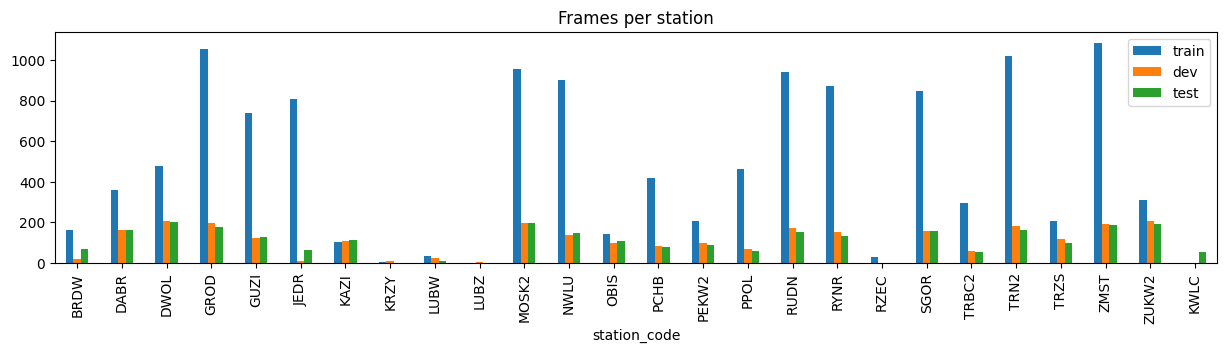

In [6]:
frames_per_station = []
for split in splits: 
    frames_per_station.append(data.get_split(split).metadata.groupby('station_code').count()['index'])
    
frames_per_station = pd.DataFrame(frames_per_station, index=splits).transpose()
frames_per_station.plot(kind='bar', figsize=(15,3), title='Frames per station')


## Calculate MAE per station for train/dev/test set

In [7]:


stations = data.metadata.station_code.unique()

results = []

for split in splits: 
    split_results = {}
    print(split)
    for station in stations: 
        print(station)
        split_results[station] = {'mae':[], 'loss':[]}
        for i in range(10):
            gen = train.get_data_generator(split=split, station=station, sampling_rate=sampling_rate, path=data_path)
            data_loader = DataLoader(gen, batch_size=256, shuffle=False, num_workers=0,
                                    worker_init_fn=worker_seeding)
        
            test_loss, test_mae = None, None
            try: 
                test_loss, test_mae = train.test_one_epoch(model, data_loader, pick_mae, wandb_log=False)
                test_mae = float(test_mae)
        
            except Exception as e: 
                print(e)
        
            split_results[station]['mae'].append(test_mae)
            split_results[station]['loss'].append(test_loss)
    results.append(split_results)
        
    
    
    

train
BRDW
train (12444, 17) 100
using random window
Test avg loss: 0.029197
Test avg mae: 0.101062

train (12444, 17) 100
using random window
Test avg loss: 0.028921
Test avg mae: 0.080500

train (12444, 17) 100
using random window
Test avg loss: 0.029244
Test avg mae: 0.086313

train (12444, 17) 100
using random window
Test avg loss: 0.029136
Test avg mae: 0.099563

train (12444, 17) 100
using random window
Test avg loss: 0.029101
Test avg mae: 0.100688

train (12444, 17) 100
using random window
Test avg loss: 0.028700
Test avg mae: 0.079062

train (12444, 17) 100
using random window
Test avg loss: 0.029309
Test avg mae: 0.098625

train (12444, 17) 100
using random window
Test avg loss: 0.029184
Test avg mae: 0.084937

train (12444, 17) 100
using random window
Test avg loss: 0.029323
Test avg mae: 0.086125

train (12444, 17) 100
using random window
Test avg loss: 0.029393
Test avg mae: 0.103312

GROD
train (12444, 17) 100
using random window
Test avg loss: 0.025653
Test avg mae: 0.06

#### Plot results

/Users/krystynamilian/virtualenvs/epos/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/krystynamilian/virtualenvs/epos/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/krystynamilian/virtualenvs/epos/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/krystynamilian/virtualenvs/epos/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/krystynamilian/virtualenvs/epos/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/krystynamilian/virtualenvs/epos/lib/python3.9/site

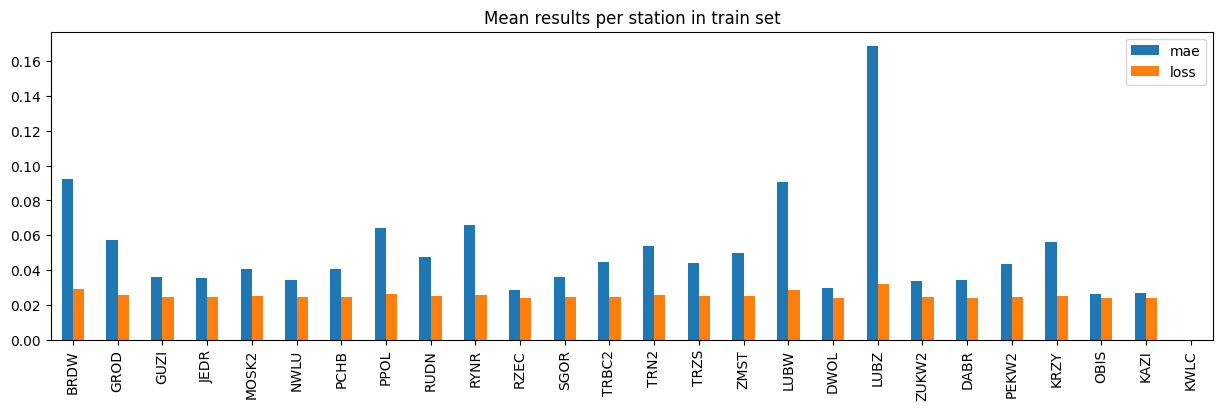

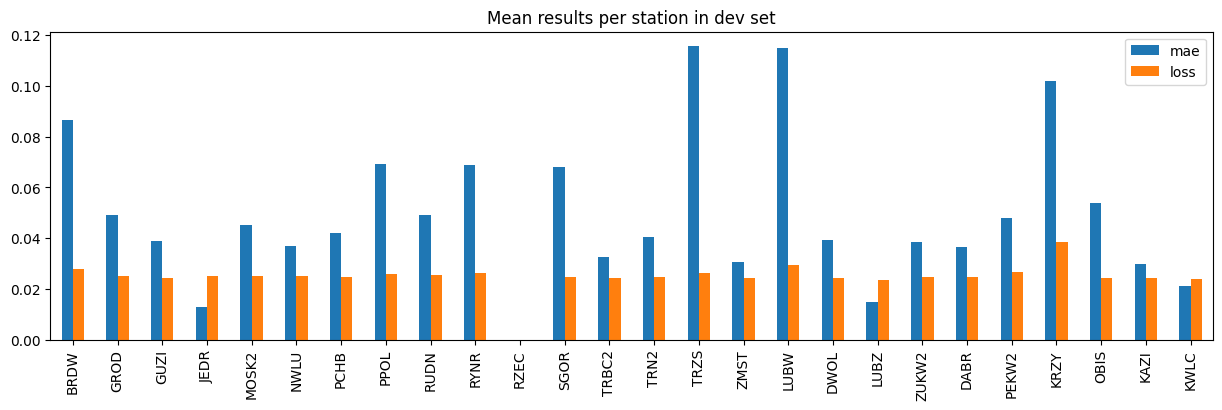

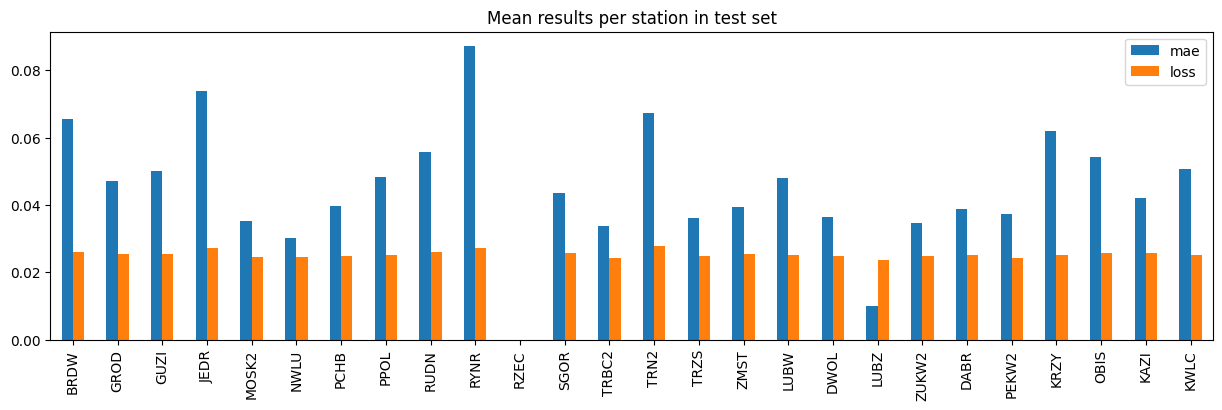

In [8]:
results_df = []
for i, split in enumerate(splits): 
    df = pd.DataFrame(results[i]).transpose()

    for station, values in df[['mae']].itertuples():
        df.loc[station, 'mae'] =  np.mean([v for v in values if v is not None]) 
    for station, values in df[['loss']].itertuples():
        df.loc[station, 'loss'] =  np.mean([v for v in values if v is not None]) 
        
    df.plot(kind='bar', figsize=(15,4), title=f"Mean results per station in {split} set")

    results_df.append(df)

In [9]:
### Check correlation between trainin data size and obtained results

In [10]:
stats = frames_per_station.copy()

In [11]:
stats['train_mae'] = results_df[0]['mae']
stats['dev_mae'] = results_df[1]['mae']
stats['test_mae'] = results_df[2]['mae']

<Axes: xlabel='train', ylabel='train_mae'>

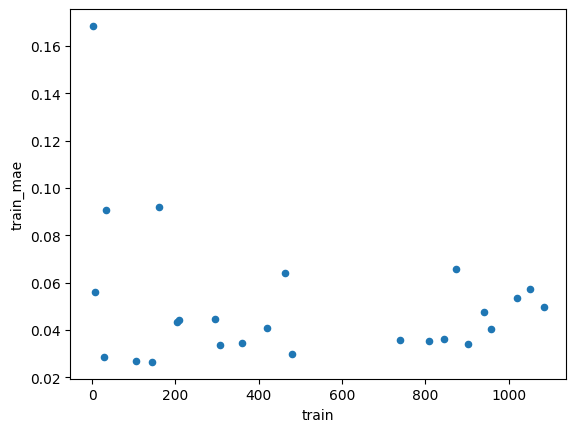

In [12]:
stats.plot(kind='scatter', x ='train', y='train_mae')

In [13]:
stats

train    dev   test train_mae   dev_mae  test_mae
station_code                                                    
BRDW           160.0   20.0   67.0  0.092019   0.08675  0.065433
DABR           359.0  161.0  160.0  0.034323  0.036516  0.038706
DWOL           479.0  206.0  200.0   0.02986  0.039102  0.036385
GROD          1052.0  197.0  175.0   0.05752  0.049132  0.047029
GUZI           740.0  121.0  126.0  0.035936  0.038777  0.050024
JEDR           809.0    9.0   62.0  0.035391     0.013  0.073871
KAZI           105.0  110.0  114.0  0.026905  0.029736  0.042184
KRZY             7.0   11.0    1.0     0.056  0.101909     0.062
LUBW            33.0   24.0   10.0  0.090697     0.115    0.0481
LUBZ             2.0    3.0    1.0    0.1685     0.015      0.01
MOSK2          958.0  197.0  199.0  0.040543   0.04536  0.035337
NWLU           902.0  138.0  149.0   0.03412  0.036971  0.030188
OBIS           145.0   97.0  106.0   0.02649  0.053753  0.054094
PCHB           420.0   82.0   79.0  0.040777  0.042024  0.039608
PEKW2          205.0   97.0   87.0  0.043195   0.04801  0.037368
PPOL           463.0   67.0   59.0  0.064004   0.06909  0.048424
RUDN           941.0  172.0  152.0  0.047671  0.049262  0.055829
RYNR           874.0  151.0  135.0  0.065755  0.068841  0.087104
RZEC            29.0    NaN    NaN  0.028448       NaN       NaN
SGOR           845.0  155.0  158.0  0.036054  0.068084  0.043418
TRBC2          295.0   59.0   55.0  0.044679  0.032559  0.033709
TRN2          1020.0  181.0  162.0  0.053552  0.040359  0.067352
TRZS           209.0  116.0   97.0  0.044144  0.115612  0.036155
ZMST          1084.0  191.0  189.0  0.049537  0.030513  0.039323
ZUKW2          308.0  206.0  190.0  0.033697  0.038471  0.034626
KWLC             NaN    2.0   52.0       NaN     0.021  0.050538

### Check predictions for stations with highest MAE

In [14]:
dev_res = results_df[1]
station_with_worst_res_dev_set = dev_res[dev_res.mae == dev_res.mae.max()].index[0]
highest_dev_mae = dev_res.loc[station_with_worst_res_dev_set, 'mae']

test_res = results_df[2]
station_with_worst_res_test_set = test_res[test_res.mae == test_res.mae.max()].index[0]
highest_test_mae = test_res.loc[station_with_worst_res_test_set, 'mae']
print(f"highest mean MAE in dev set: {highest_dev_mae:.2f} for station: {station_with_worst_res_dev_set}")
print(f"highest mean MAE in test set: {highest_test_mae:.2f} for station: {station_with_worst_res_test_set}")





highest mean MAE in dev set: 0.12 for station: TRZS
highest mean MAE in test set: 0.09 for station: RYNR


In [15]:
def plot_sample(sample, model, i, desc=None): 
    fig = plt.figure(figsize=(15, 10))
    
    axs = fig.subplots(2, 1, sharex=True, gridspec_kw={"hspace": 0, "height_ratios": [3,  2]})
    axs[0].plot(sample["X"][0].T, label='x')
    plt.legend()
    axs[1].plot(sample["y"][0].T, label='y')
    
    model.eval()  # close the model for evaluation
    
    with torch.no_grad():
        pred = model(torch.tensor(sample["X"], device=model.device).unsqueeze(0))  # Add a fake batch dimension
        pred = pred[0].cpu().numpy()
        
        axs[1].plot(pred[0], label='pred', color='orange')
        plt.legend()

        pred_pick_idx  = np.argmax(pred[0])
        true_pick_idx = np.argmax(sample['y'][0])

        
        
        mae_error = np.abs(pred_pick_idx - true_pick_idx) /100 #mae in seconds

        fig.suptitle(f"Predictions for sample: {i} {desc}, mae: {mae_error}s")
        
        plt.show()
        
    

### Find random samples that reproduce obtained results 

Results are not deterministic, because samples generator used during training augments samples by introducing random padding, see https://seisbench.readthedocs.io/en/stable/pages/documentation/generate.html?highlight=generate#seisbench.generate.windows.RandomWindow

In [16]:
##### dev set

dev (2773, 17) 100
using random window
dev (2773, 17) 100
using random window
dev (2773, 17) 100
using random window
dev (2773, 17) 100
using random window
dev (2773, 17) 100
using random window
dev (2773, 17) 100
using random window
dev (2773, 17) 100
using random window
dev (2773, 17) 100
using random window


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[1.594e+01 4.900e-01 4.500e-01 2.600e-01 2.000e-01 1.300e-01 1.200e-01
 1.200e-01 1.000e-01 9.000e-02 9.000e-02 8.000e-02 8.000e-02 6.000e-02
 6.000e-02 6.000e-02 6.000e-02 6.000e-02 6.000e-02 6.000e-02 5.000e-02
 5.000e-02 5.000e-02 5.000e-02 4.000e-02 4.000e-02 4.000e-02 4.000e-02
 4.000e-02 4.000e-02 4.000e-02 4.000e-02 4.000e-02 4.000e-02 3.000e-02
 3.000e-02 3.000e-02 3.000e-02 3.000e-02 3.000e-02 3.000e-02 3.000e-02
 3.000e-02 3.000e-02 3.000e-02 3.000e-02 3.000e-02 3.000e-02 3.000e-02
 3.000e-02 3.000e-02 3.000e-02 3.000e-02 2.000e-02 2.000e-02 2.000e-02
 2.000e-02 2.000e-02 2.000e-02 2.000e-02 2.000e-02 2.000e-02 2.000e-02
 2.000e-02 2.000e-02 2.000e-02 2.000e-02 2.000e-02 2.000e-02 2.000e-02
 2.000e-02 2.000e-02 2.000e-02 2.000e-02 2.000e-02 2.000e-02 1.000e-02
 1.000e-02 1.000e-02 1.000e-02 1.000e-02 1.000e-02 1.000e-02 1.000e-02
 1.000e-02 1.000e-02 1.000e-02 1.000e-02 1.000e-02 1.000e-02 1.000e-02
 1.000e-02 1.000e-02 1.000e-02 1.000e-02 1.000e-02 1.000e-02 1.000e-02
 1.000

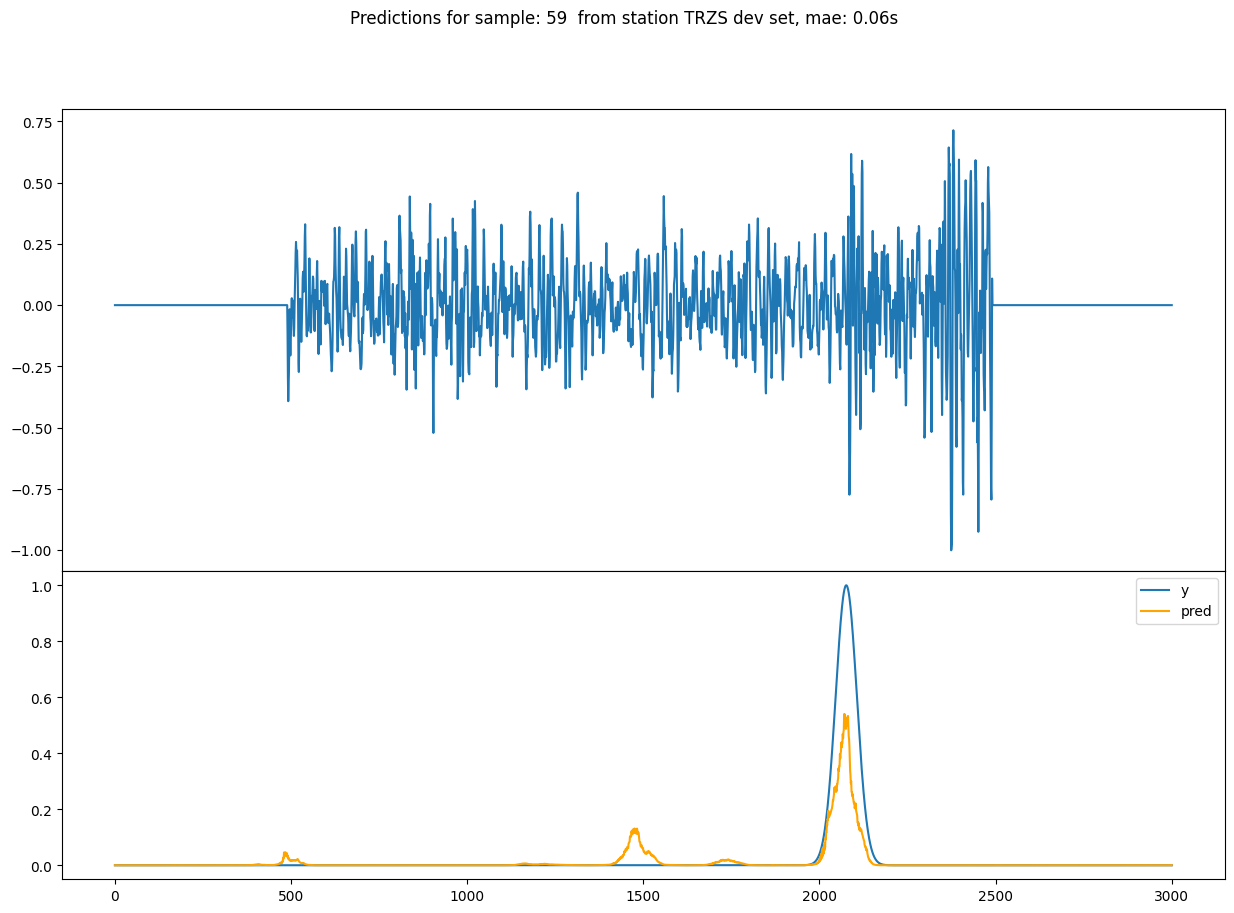

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


0 0.49


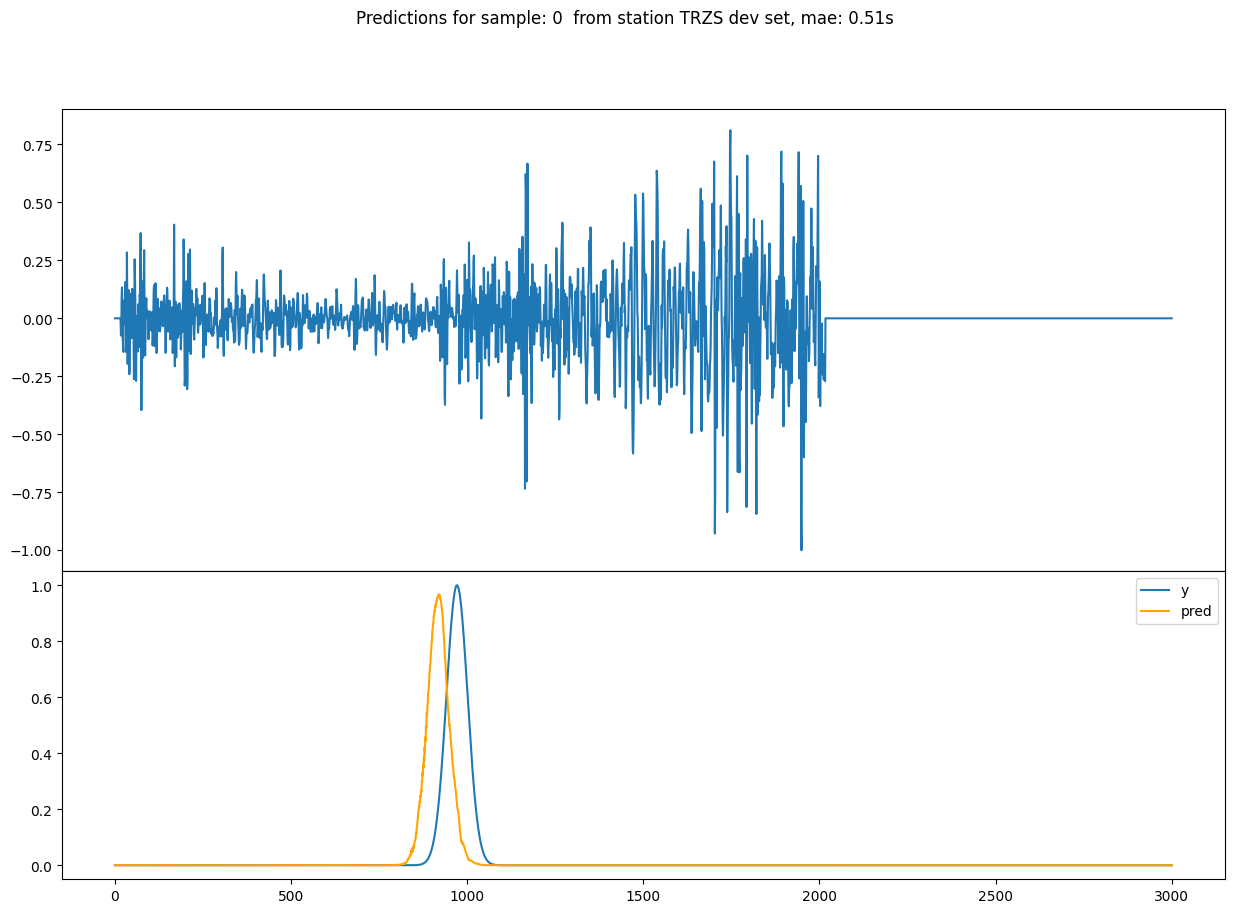

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


53 0.45


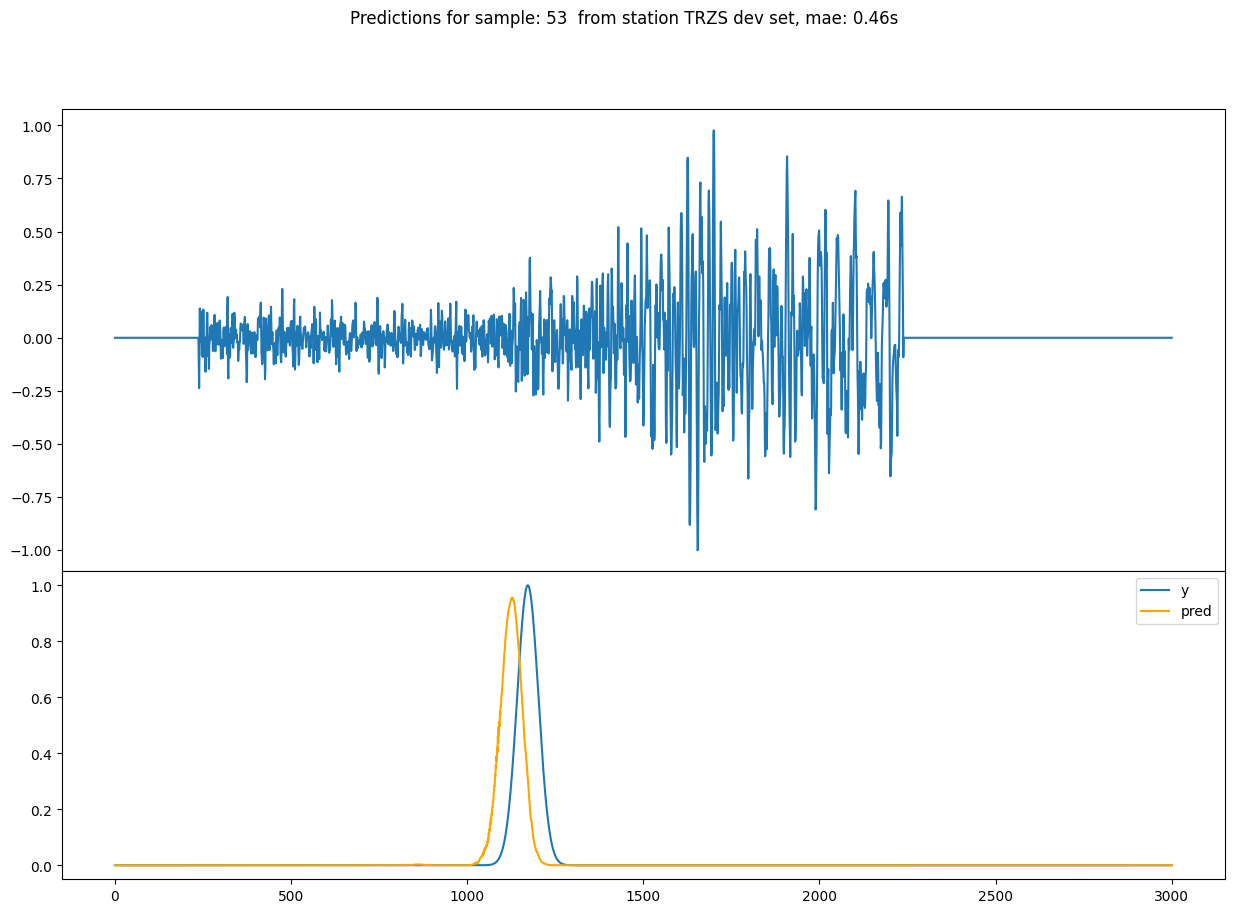

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


110 0.26


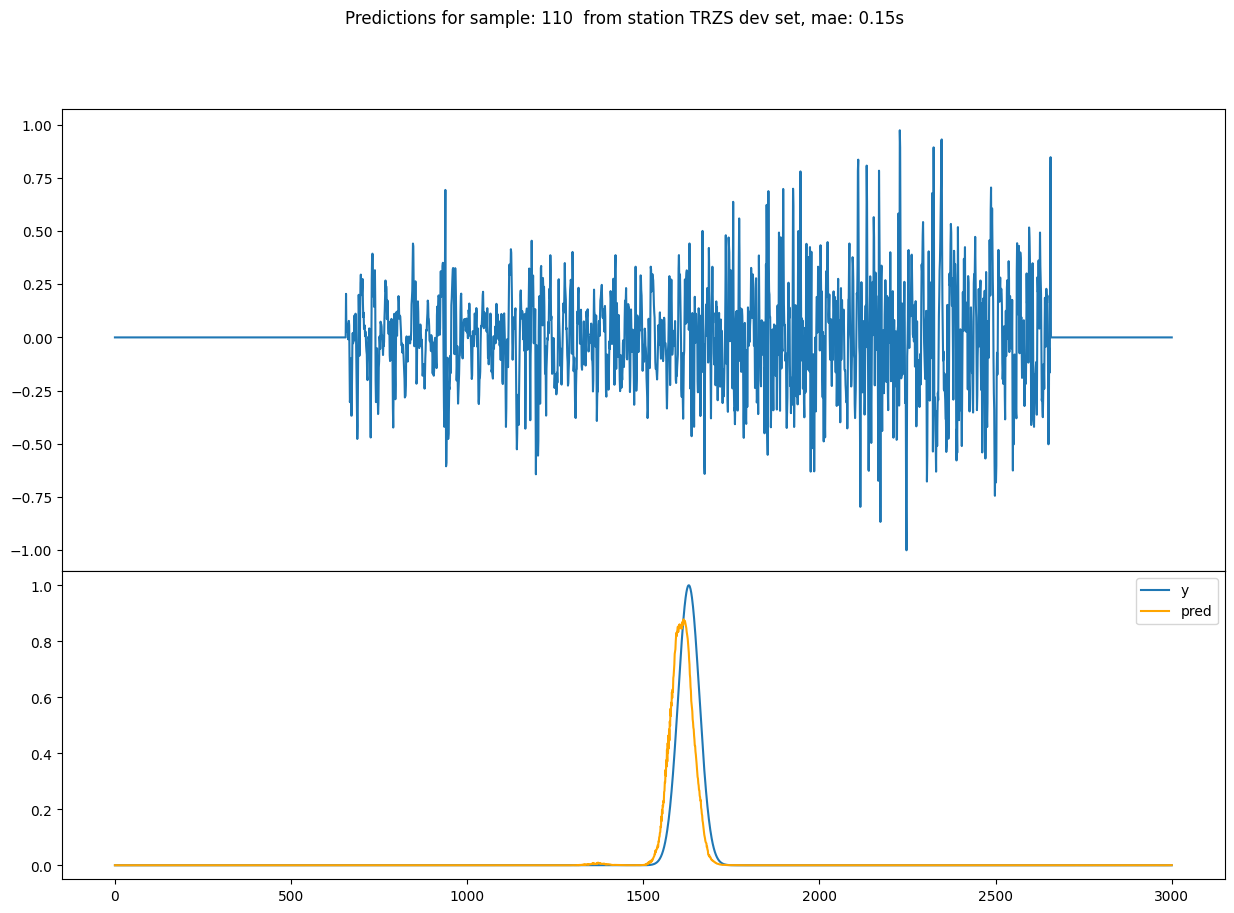

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


64 0.2


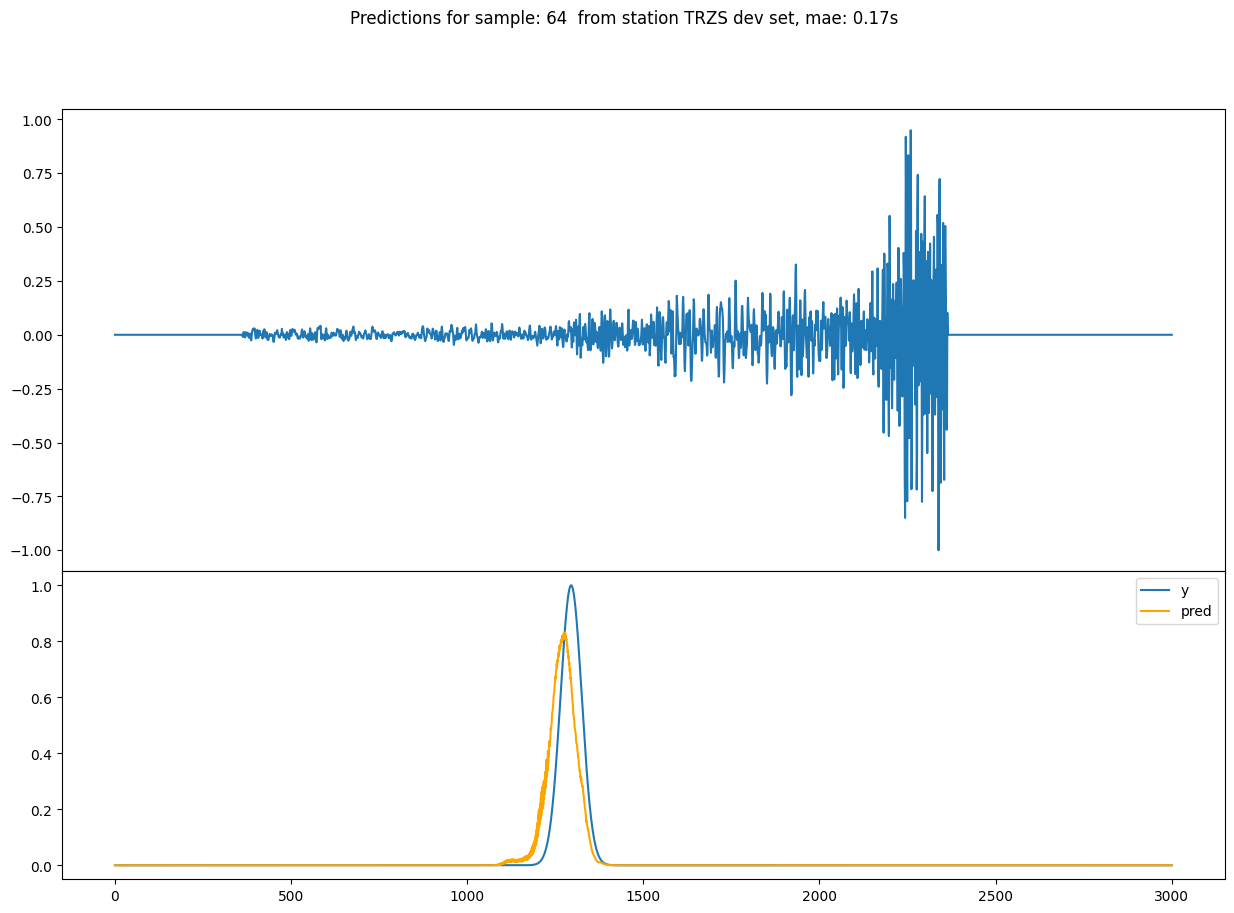

In [17]:

mean_mae = 0
samples = []
split = 'dev'
station = station_with_worst_res_dev_set

while mean_mae < highest_dev_mae: 

    gen = train.get_data_generator(split=split, station=station , sampling_rate=sampling_rate, path=data_path)
    station_mae = []
    with torch.no_grad():
        for i in range(len(gen)): 
            # idx = np.random.randint(len(gen))
            idx = i
            sample = gen[idx]
            samples.append(sample)
            pred = model(torch.tensor(sample["X"], device=model.device).unsqueeze(0))  
            pred = pred[0].cpu().numpy()
    
            pred_pick_idx  = np.argmax(pred[0])
            true_pick_idx = np.argmax(sample['y'][0])            
                
            mae_error = np.abs(pred_pick_idx - true_pick_idx) /100 #mae in seconds
            station_mae.append(mae_error)
    
    sorted = np.argsort(station_mae)[::-1]
    mean_mae = np.mean(station_mae)

print(np.array(station_mae)[sorted])


## plot samples with mae error at leas 0.2s
for idx in sorted:
    if station_mae[idx] < 0.2: 
        break
    print(idx, station_mae[idx])
    plot_sample(samples[idx], model, idx, desc=f" from station {station} {split} set")



test (2785, 17) 100
using random window
test (2785, 17) 100
using random window


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[ 91  40  63 106  28 119 100  33 129 105  42  54  86  32 130  24  61   3
  79  73  67  89 128 124  76  50  46  36  71  31   5  83  98 126  18  21
  77   2 134 114 127 109 125  22  30  23  20  81  15  43  44  45 113  49
  96  51  74  94 117  52 118  95 122  57 123  14  13  12   9   8   7   6
 131 132  56  47  65  93  90  97 110  87  75  85 108 102  80  59  25 104
  19  58  17  82  84  11  10   4 120   0  68  55  48  69 112  53  38  39
  37  60 116  66 111  92 101  88  62  99  64   1  34 133  16  35  70  41
  78 103 115  26  27 121 107  72  29]
[3.12 2.56 1.23 0.5  0.37 0.23 0.22 0.14 0.13 0.12 0.11 0.1  0.1  0.09
 0.09 0.08 0.08 0.08 0.07 0.07 0.07 0.07 0.07 0.06 0.06 0.06 0.06 0.06
 0.05 0.05 0.05 0.05 0.05 0.05 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04
 0.04 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03
 0.03 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02
 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02
 0.02 0.02 0.01 0.01 0.01

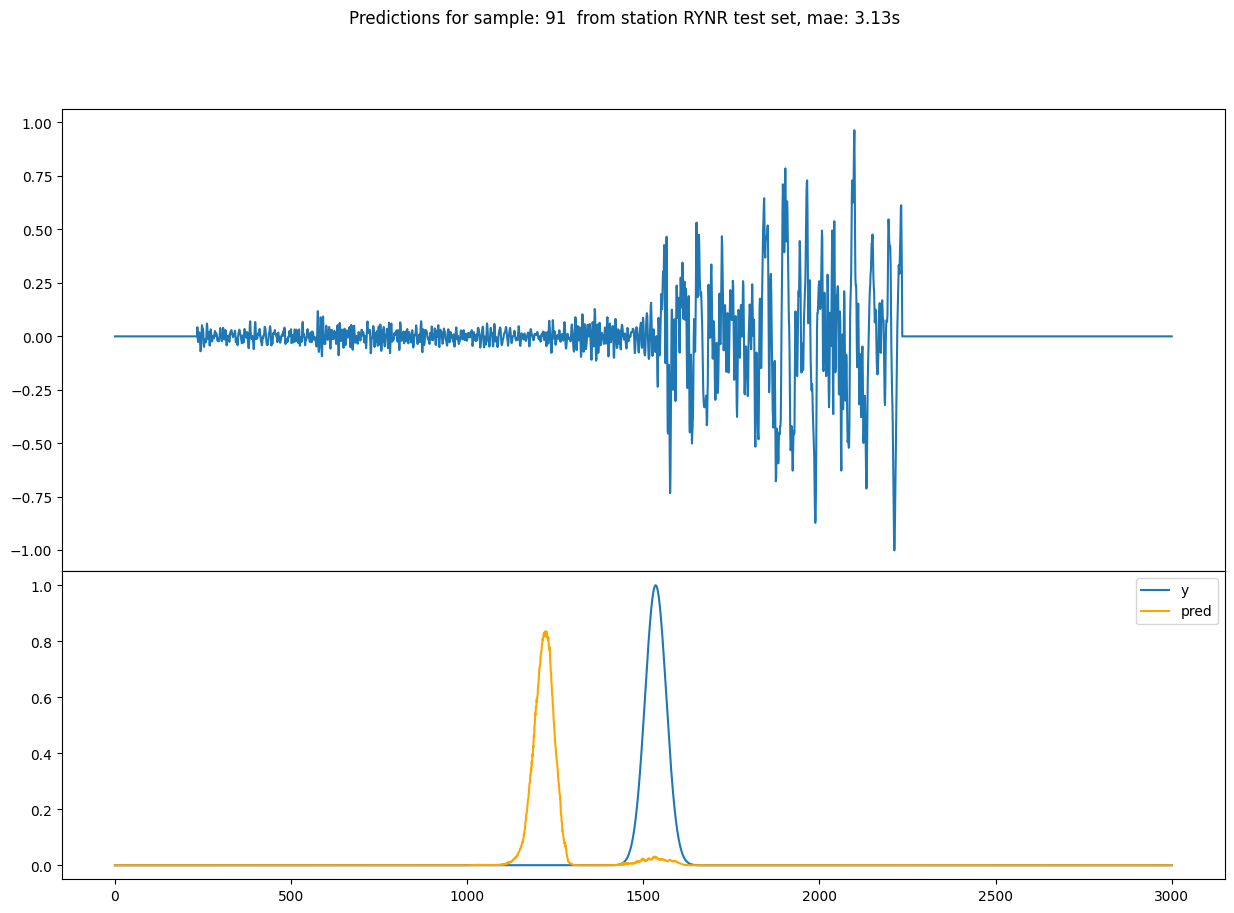

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


40 2.56


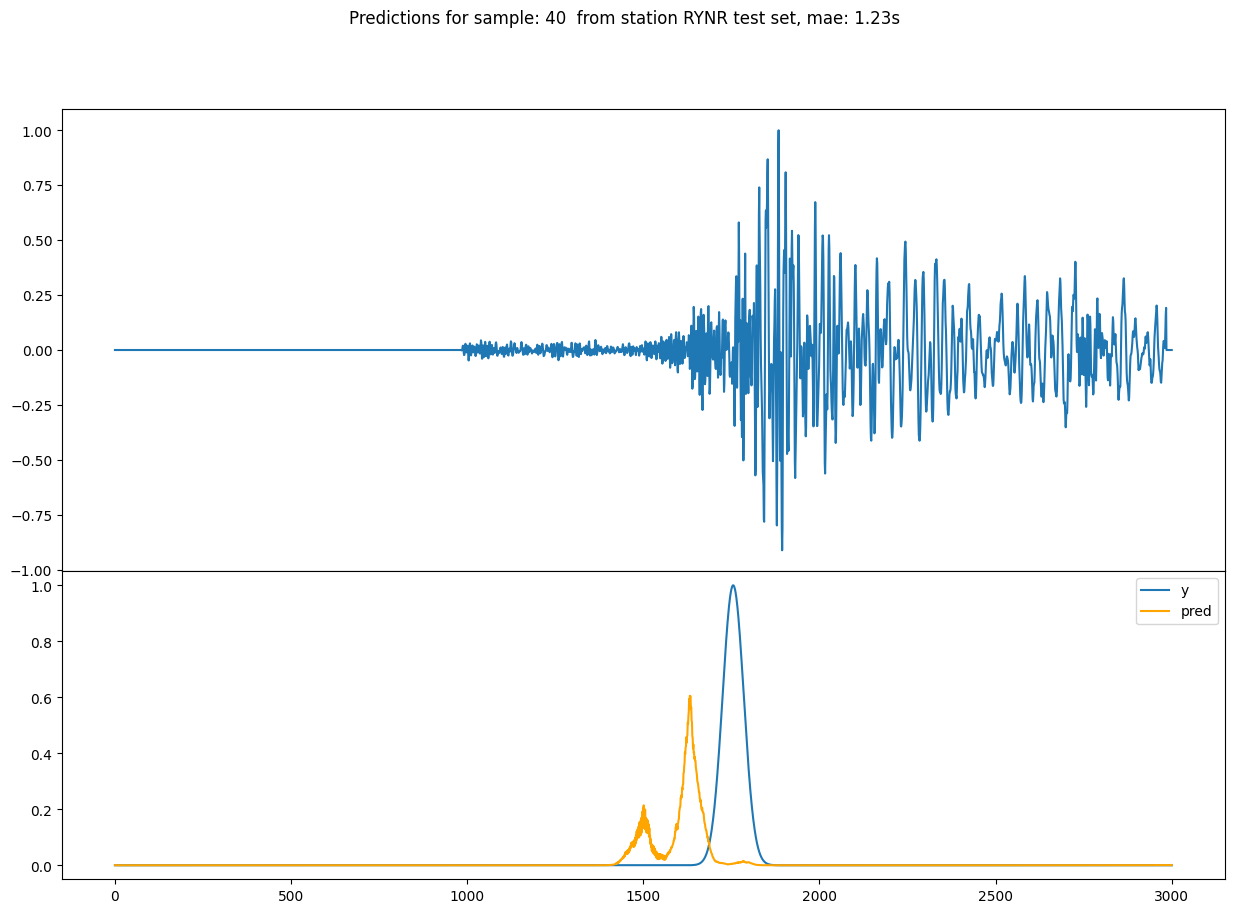

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


63 1.23


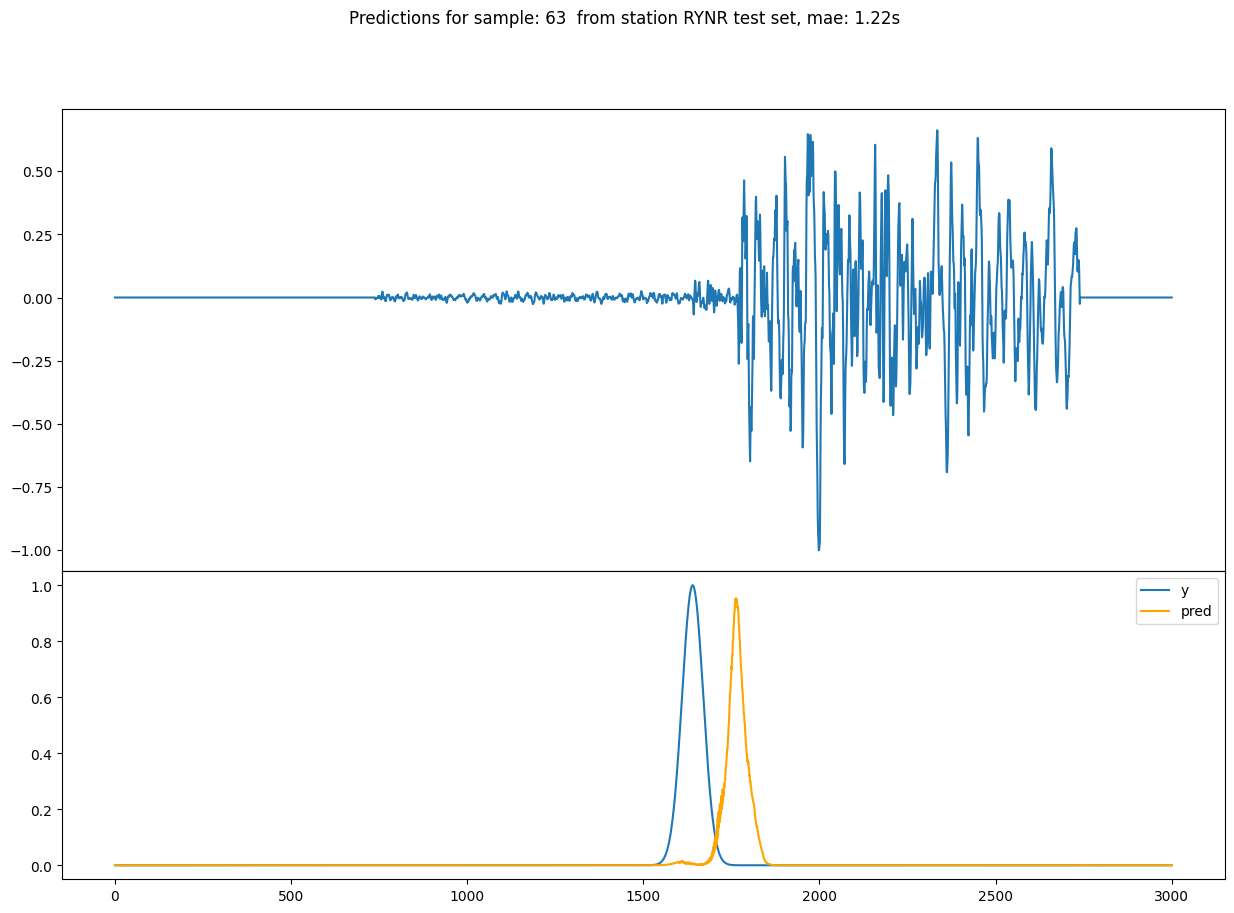

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


106 0.5


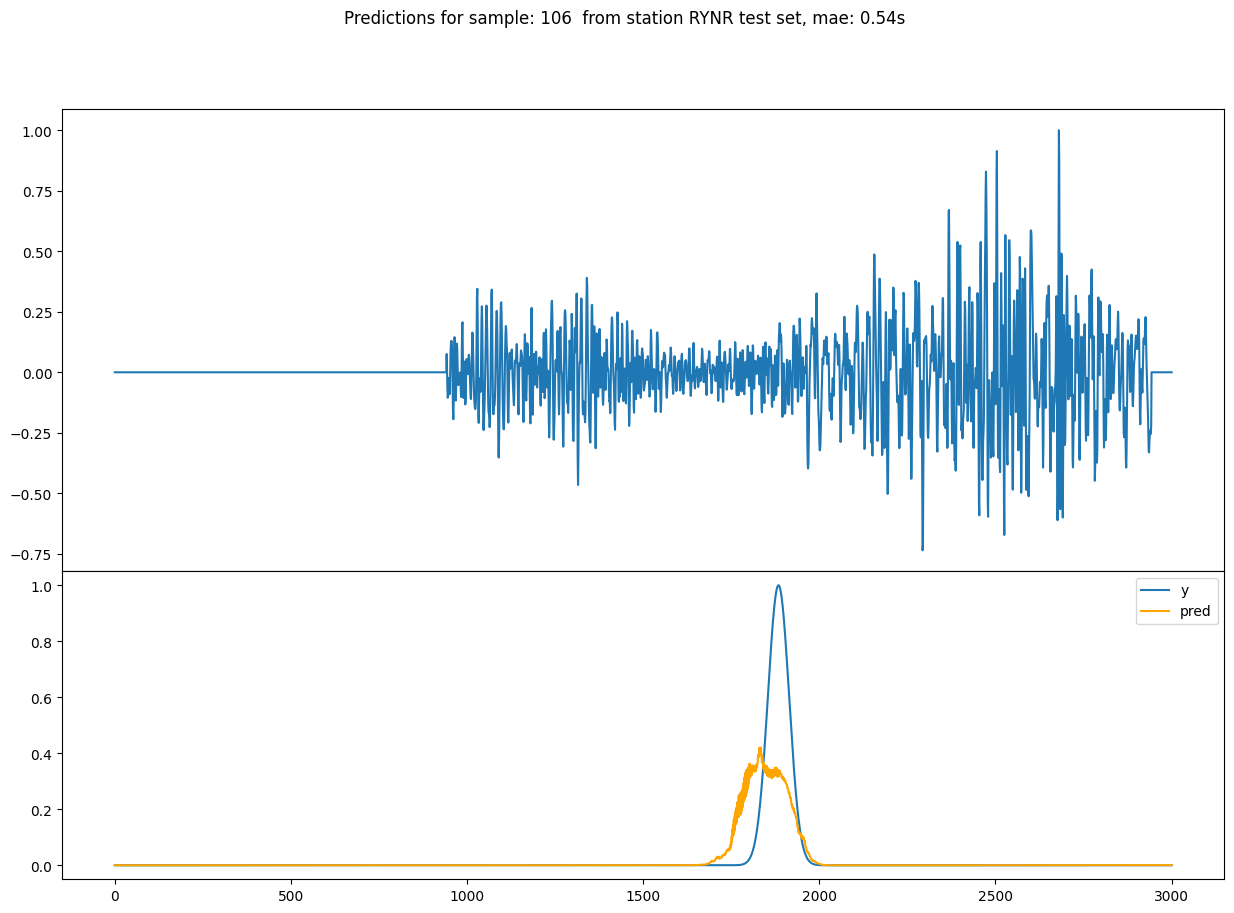

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


28 0.37


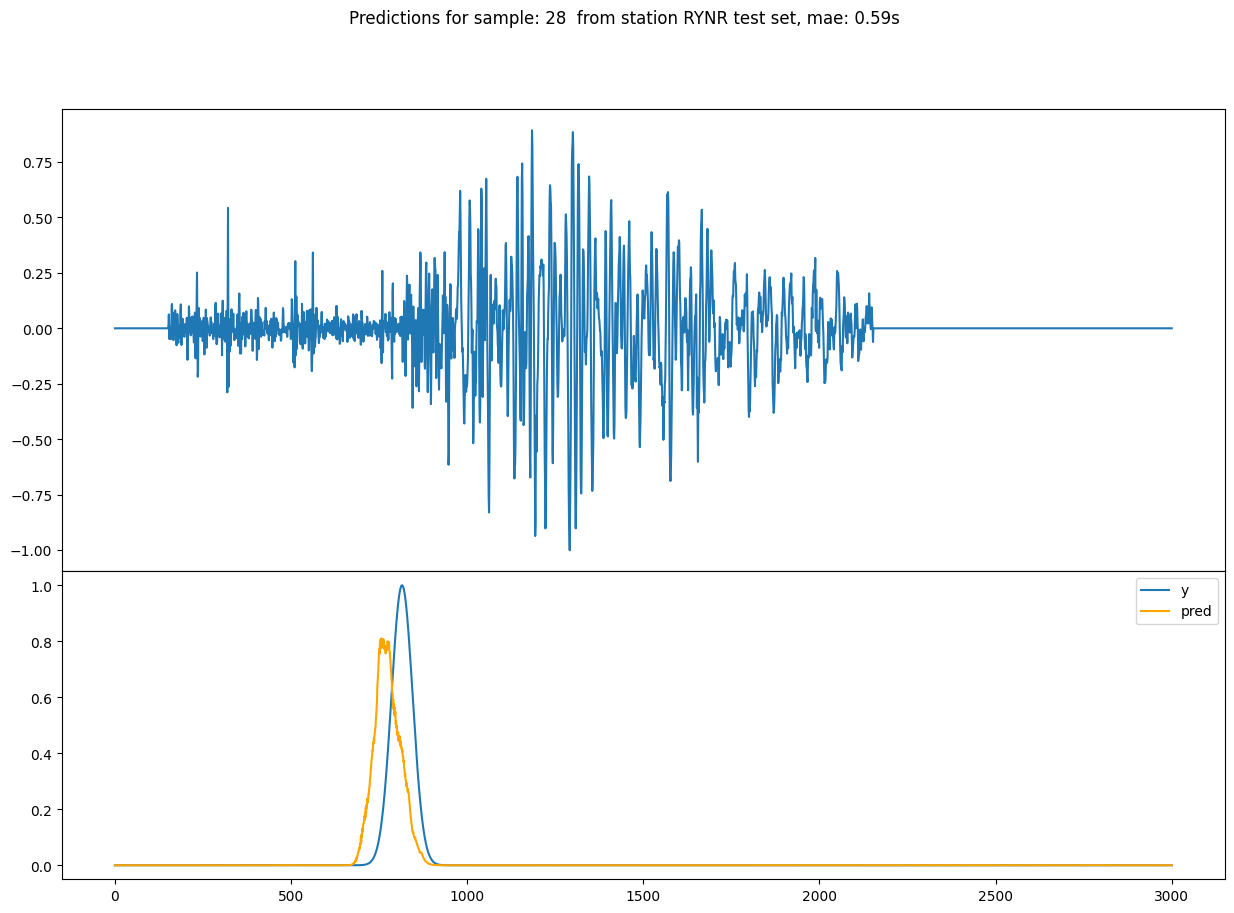

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


119 0.23


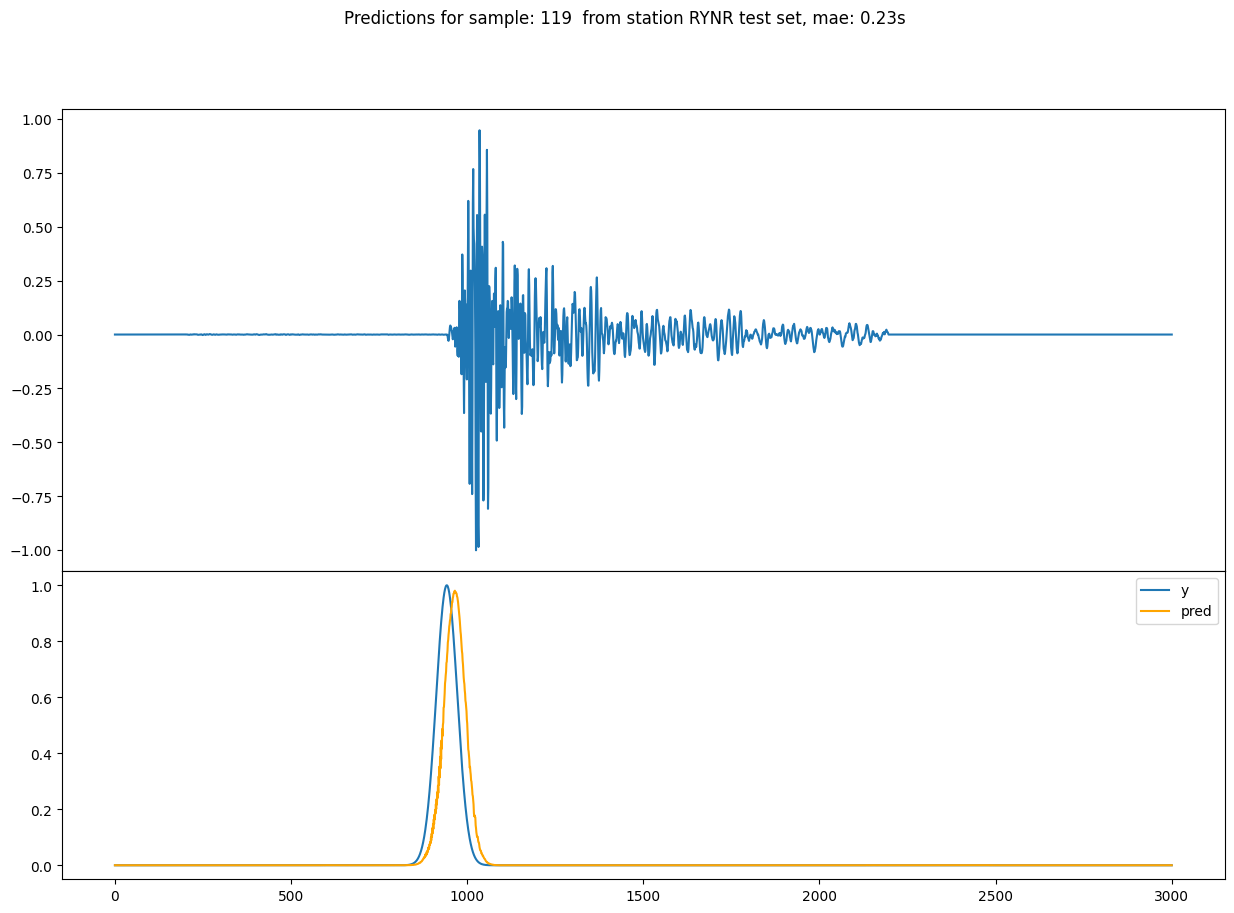

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


100 0.22


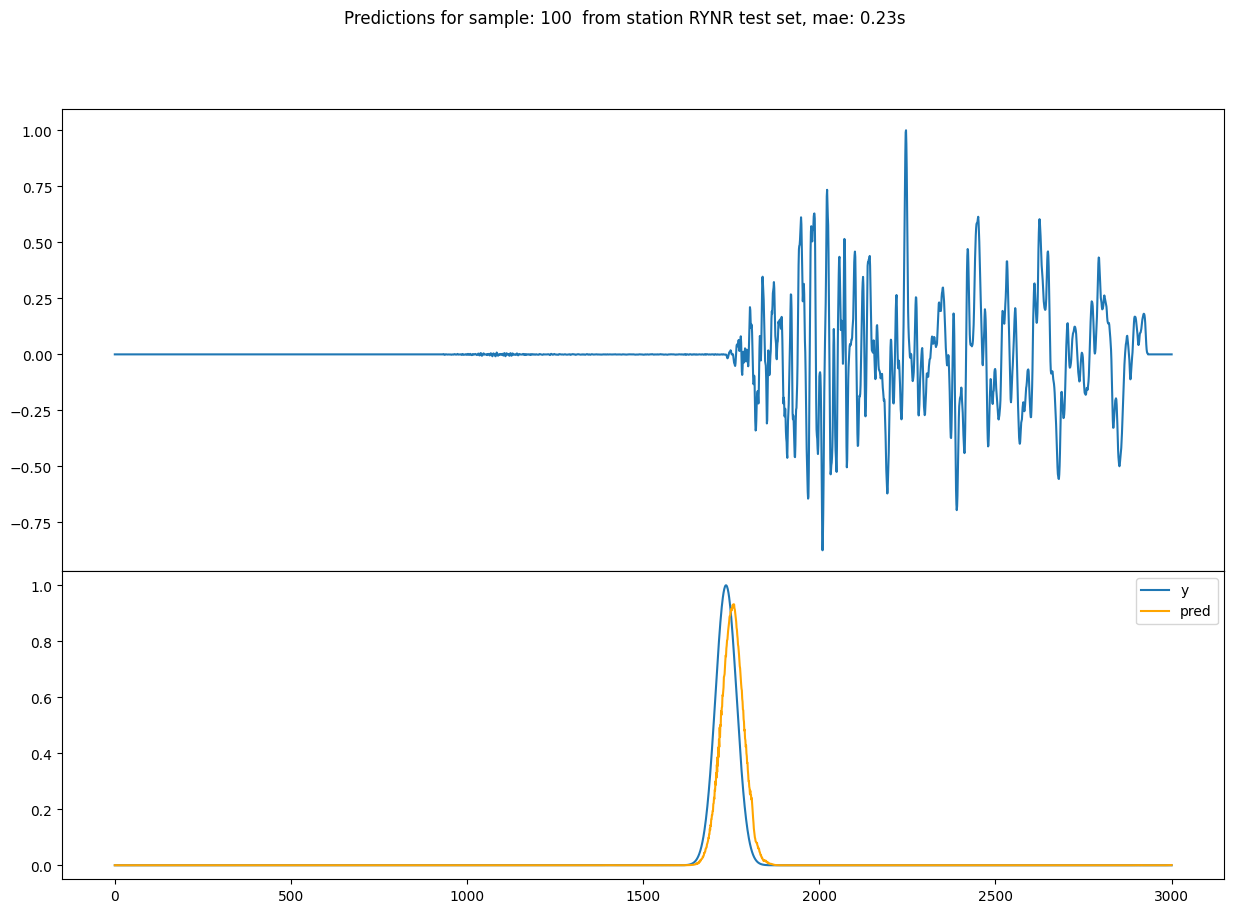

In [18]:

mean_mae = 0
samples = []
split = 'test'
station = station_with_worst_res_test_set

while mean_mae < highest_test_mae: 

    gen = train.get_data_generator(split=split, station=station , sampling_rate=sampling_rate, path=data_path)
    station_mae = []
    with torch.no_grad():
        for i in range(len(gen)): 
            # idx = np.random.randint(len(gen))
            idx = i
            sample = gen[idx]
            samples.append(sample)
            pred = model(torch.tensor(sample["X"], device=model.device).unsqueeze(0))  
            pred = pred[0].cpu().numpy()
    
            pred_pick_idx  = np.argmax(pred[0])
            true_pick_idx = np.argmax(sample['y'][0])            
                
            mae_error = np.abs(pred_pick_idx - true_pick_idx) /100 #mae in seconds
            station_mae.append(mae_error)
    
    sorted = np.argsort(station_mae)[::-1]
    mean_mae = np.mean(station_mae)

print(sorted)
print(np.array(station_mae)[sorted])


## plot samples with mae error at leas 0.2s
for idx in sorted:
    if station_mae[idx] < 0.2: 
        break
    print(idx, station_mae[idx])
    plot_sample(samples[idx], model, idx, desc=f" from station {station} {split} set")



In [19]:
data.test().metadata.iloc[idx]

index                                            30312
source_origin_time             2021-08-24 03:01:23.500
source_latitude_deg                      5714247.36402
source_longitude_deg                    5578128.427708
source_depth_km                                    0.8
source_magnitude                              1.522222
split                                             test
station_network_code                                PL
station_code                                     MOSK2
trace_channel                                      EHE
trace_sampling_rate_hz                           100.0
trace_start_time           2021-08-24T03:01:17.360000Z
trace_Pg_arrival_sample                          727.0
trace_name                        bucket29$66,:3,:2001
trace_Sg_arrival_sample                            NaN
trace_chunk                                           
trace_component_order                              ZNE
Name: 30312, dtype: object

In [20]:
idx

33

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


test (2785, 17) 100
using random window


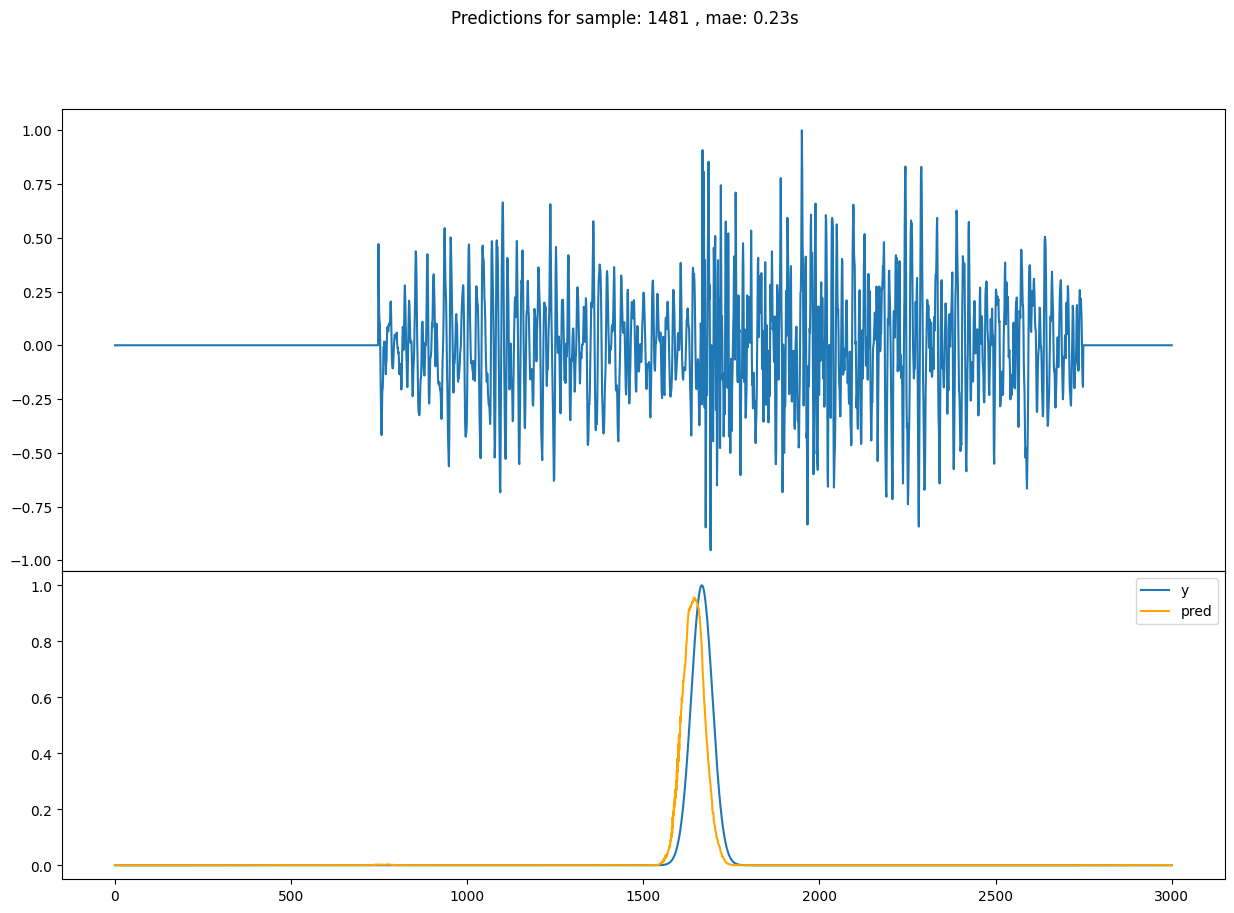

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


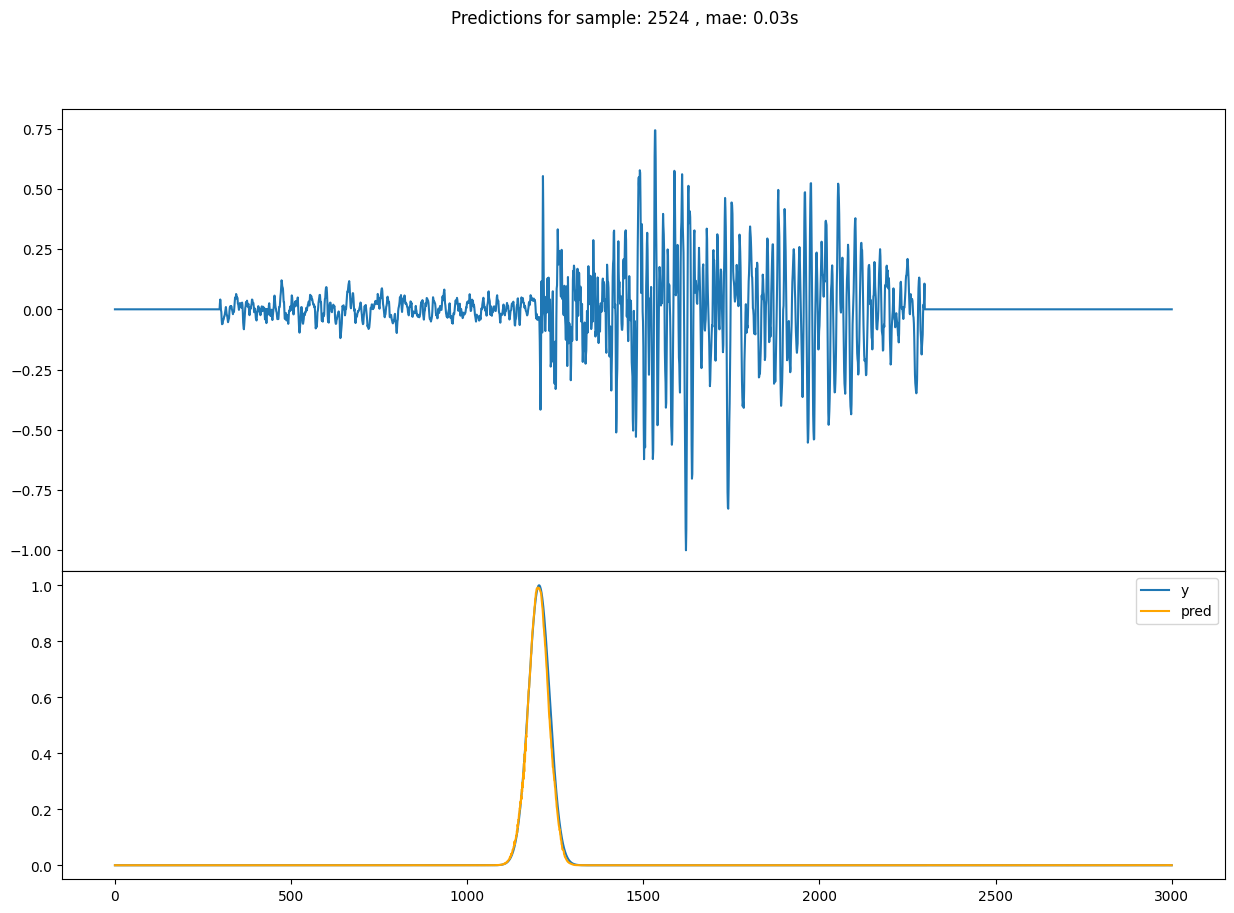

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


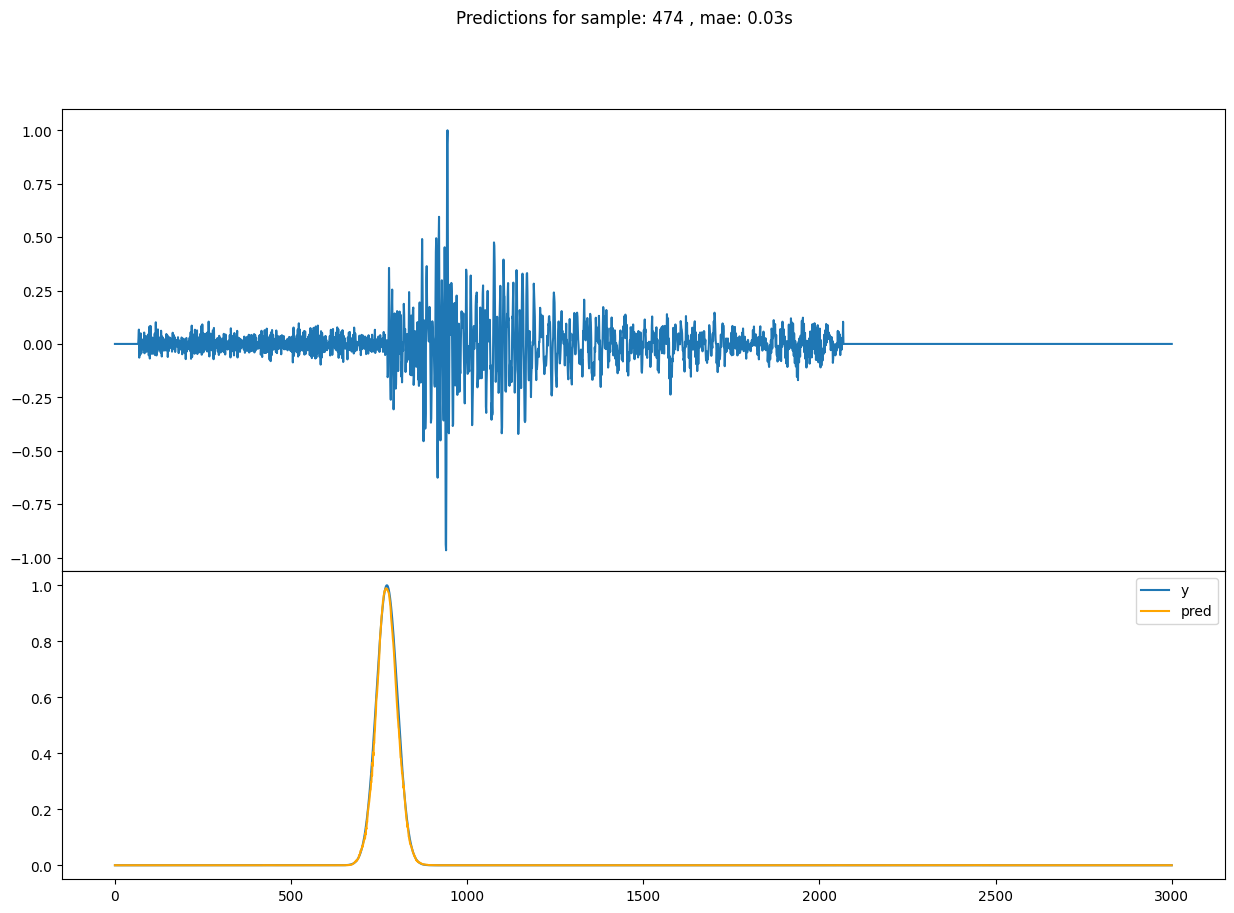

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


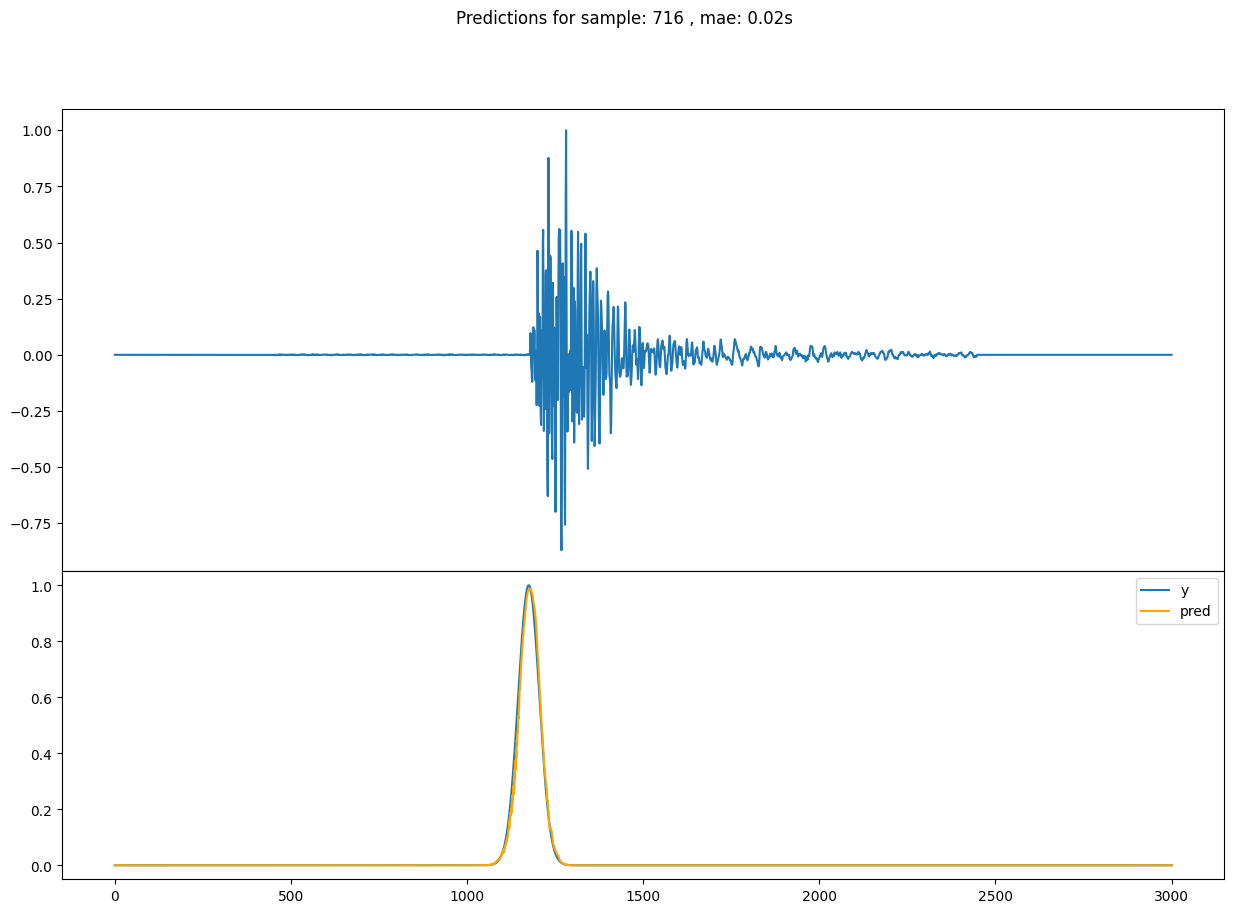

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


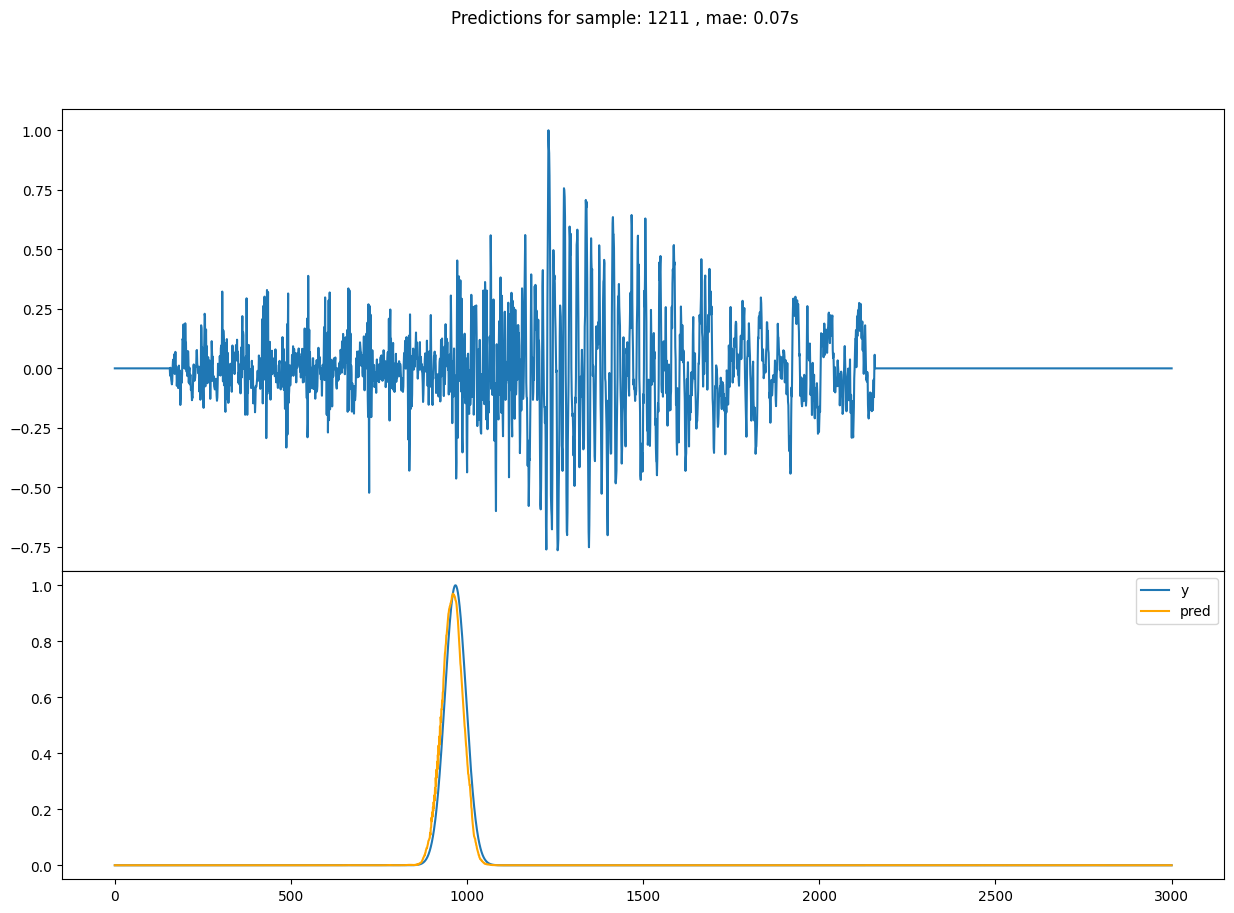

In [21]:
gen = train.get_data_generator(split='test', station=None , sampling_rate=sampling_rate, path=data_path)

for i in range(5): 
    idx = np.random.randint(len(gen))
    sample = gen[idx]
    
    plot_sample(sample, model, idx, desc="")



In [22]:
sample

{'X': array([[-2.9614418e-19, -2.9614418e-19, -2.9614418e-19, ...,
         -2.9614418e-19, -2.9614418e-19, -2.9614418e-19],
        [-6.4017395e-19, -6.4017395e-19, -6.4017395e-19, ...,
         -6.4017395e-19, -6.4017395e-19, -6.4017395e-19],
        [-1.0255816e-18, -1.0255816e-18, -1.0255816e-18, ...,
         -1.0255816e-18, -1.0255816e-18, -1.0255816e-18]], dtype=float32),
 'y': array([[2.43596292e-226, 7.12942807e-226, 2.08428048e-225, ...,
         0.00000000e+000, 0.00000000e+000, 0.00000000e+000],
        [1.00000000e+000, 1.00000000e+000, 1.00000000e+000, ...,
         1.00000000e+000, 1.00000000e+000, 1.00000000e+000]])}